In [2]:
import sys
!git clone https://github.com/NVlabs/stylegan3.git
!pip install einops ninja

sys.path.append('./stylegan3')

fatal: destination path 'stylegan3' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import re
from typing import List, Optional, Tuple, Union
import click
import dnnlib
import numpy as np
import PIL.Image
import torch
import legacy

In [4]:
# Choose between these pretrained models

#StyleGAN2

# stylegan2-ffhq-1024x1024.pkl, stylegan2-ffhq-512x512.pkl, stylegan2-ffhq-256x256.pkl
# stylegan2-ffhqu-1024x1024.pkl, stylegan2-ffhqu-256x256.pkl
# stylegan2-metfaces-1024x1024.pkl, stylegan2-metfacesu-1024x1024.pkl
# stylegan2-afhqv2-512x512.pkl
# stylegan2-afhqcat-512x512.pkl, stylegan2-afhqdog-512x512.pkl, stylegan2-afhqwild-512x512.pkl
# stylegan2-brecahad-512x512.pkl, stylegan2-cifar10-32x32.pkl
# stylegan2-celebahq-256x256.pkl, stylegan2-lsundog-256x256.pkl

#https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/<MODEL>, 

#StyleGAN3

# stylegan3-t-ffhq-1024x1024.pkl, stylegan3-t-ffhqu-1024x1024.pkl, stylegan3-t-ffhqu-256x256.pkl
# stylegan3-r-ffhq-1024x1024.pkl, stylegan3-r-ffhqu-1024x1024.pkl, stylegan3-r-ffhqu-256x256.pkl
# stylegan3-t-metfaces-1024x1024.pkl, stylegan3-t-metfacesu-1024x1024.pkl
# stylegan3-r-metfaces-1024x1024.pkl, stylegan3-r-metfacesu-1024x1024.pkl
# stylegan3-t-afhqv2-512x512.pkl
# stylegan3-r-afhqv2-512x512.pkl

#https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/<MODEL>, 

network_pkl = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl'

In [5]:
# Copyright (c) 2021, NVIDIA CORPORATION & AFFILIATES.  All rights reserved.
#
# NVIDIA CORPORATION and its licensors retain all intellectual property
# and proprietary rights in and to this software, related documentation
# and any modifications thereto.  Any use, reproduction, disclosure or
# distribution of this software and related documentation without an express
# license agreement from NVIDIA CORPORATION is strictly prohibited.

"""Generate images using pretrained network pickle."""

def make_transform(translate: Tuple[float,float], angle: float):
    m = np.eye(3)
    s = np.sin(angle/360.0*np.pi*2)
    c = np.cos(angle/360.0*np.pi*2)
    m[0][0] = c
    m[0][1] = s
    m[0][2] = translate[0]
    m[1][0] = -s
    m[1][1] = c
    m[1][2] = translate[1]
    return m

def generate_images(
    network_pkl: str,
    seeds: List[int],
    truncation_psi: float,
    noise_mode: str,
    outdir: str,
    translate: Tuple[float,float],
    rotate: float,
    class_idx: Optional[int]
):

    print('Loading networks from "%s"...' % network_pkl)
    device = torch.device('cuda')
    with dnnlib.util.open_url(network_pkl) as f:
        G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

    os.makedirs(outdir, exist_ok=True)

    # Labels.
    label = torch.zeros([1, G.c_dim], device=device)
    if G.c_dim != 0:
        if class_idx is None:
            raise click.ClickException('Must specify class label with --class when using a conditional network')
        label[:, class_idx] = 1
    else:
        if class_idx is not None:
            print ('warn: --class=lbl ignored when running on an unconditional network')

    # Generate images.
    for seed_idx, seed in enumerate(seeds):
        print('Generating image for seed %d (%d/%d) ...' % (seed, seed_idx, len(seeds)))
        z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)

        # Construct an inverse rotation/translation matrix and pass to the generator.  The
        # generator expects this matrix as an inverse to avoid potentially failing numerical
        # operations in the network.
        if hasattr(G.synthesis, 'input'):
            m = make_transform(translate, rotate)
            m = np.linalg.inv(m)
            G.synthesis.input.transform.copy_(torch.from_numpy(m))

        img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png')


In [9]:
seed = [12]
generate_images(network_pkl, seed, 1, 'const', '/content/', (0,0), 0, 1)

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...
warn: --class=lbl ignored when running on an unconditional network
Generating image for seed 12 (0/1) ...


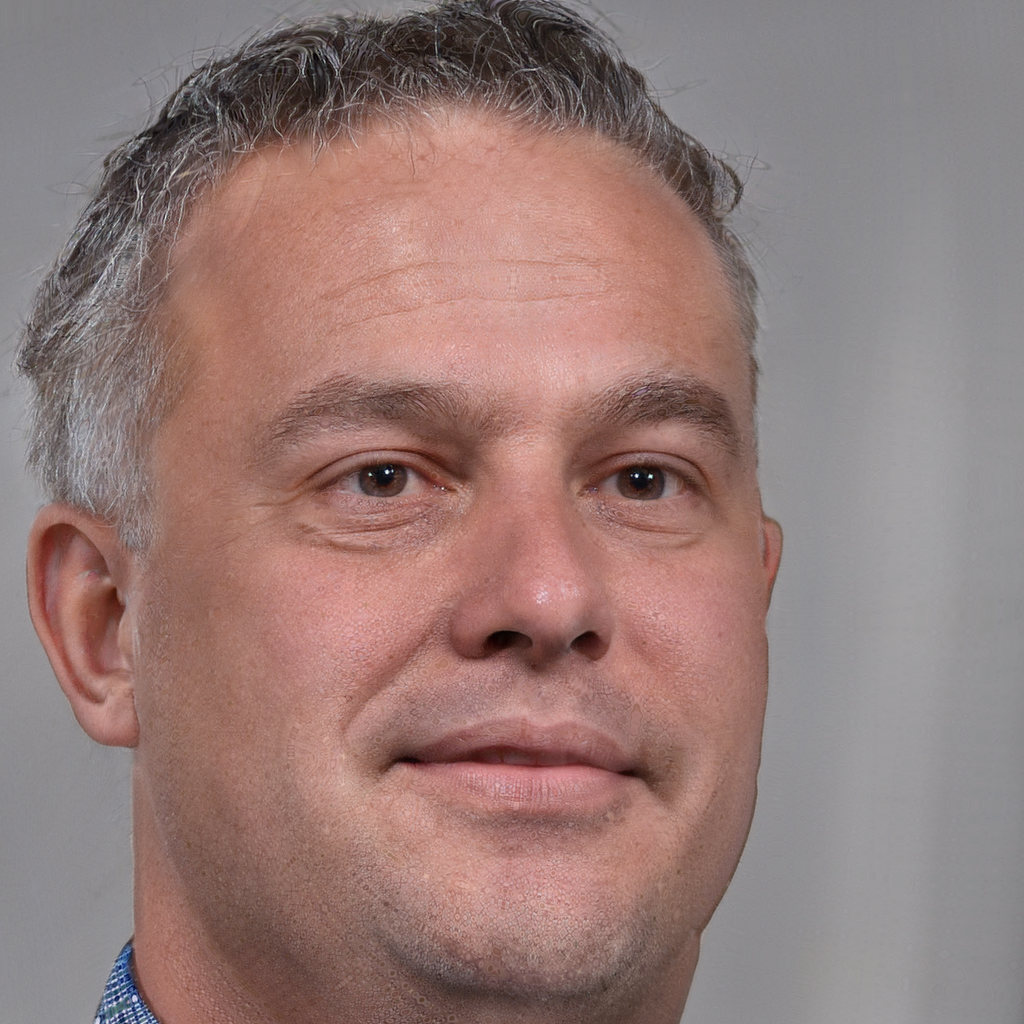

In [11]:
import PIL

im = PIL.Image.open('/content/seed0012.png')
im